# [STAT4ACSAI] Homework04: Barda, Yuwara, Danese

## Exercise 1

In [1]:
import pandas as pd
import numpy as np 

import statsmodels.formula.api as smf
from scipy.optimize import minimize
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline


sns.set(style='ticks')

![Residual explanation](imgs\\residual.PNG)

In [2]:
# Read the file
with open("Cook.txt", 'r') as cook :

    # Skip the first line as it is the header | we keep the np array as it might be usefull later
    cook = np.asarray([x.split() for x in cook.readlines()[1:]], dtype=np.float32)

    # Create the dataFrame for better handling
    dF = pd.DataFrame(cook, columns=["LogSalesVolume2020", "LogSalesVolume2021"])

In [3]:
# Check for Null values -> True = No missing Values
dF.isna().sum() == 0

LogSalesVolume2020    True
LogSalesVolume2021    True
dtype: bool

In [4]:
# Visualize the head to make sure dF is built correctly
dF.head()

,LogSalesVolume2020,LogSalesVolume2021
0,0.120,3.662
1,-0.632,3.188
2,0.670,5.433
3,-0.808,2.768
4,0.939,5.259


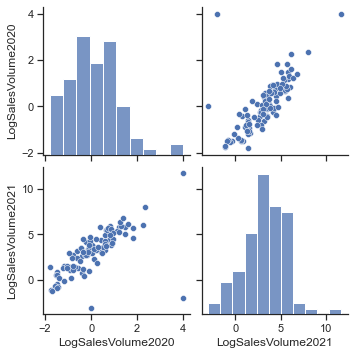

In [5]:
# Let's take a first peek at our data
sns.pairplot(dF)

![ex1](imgs\\consegna1.PNG)

In [6]:
# Let's fit OLS for predicting the 2021 sales volume with 2020 volume as the sole explanatory variable
fitted_ols = smf.ols(data = dF, formula="LogSalesVolume2021 ~ LogSalesVolume2020").fit()
print(fitted_ols.summary())

                            OLS Regression Results                            
Dep. Variable:     LogSalesVolume2021   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     102.2
Date:                Tue, 19 Jul 2022   Prob (F-statistic):           6.96e-17
Time:                        20:35:04   Log-Likelihood:                -189.51
No. Observations:                 100   AIC:                             383.0
Df Residuals:                      98   BIC:                             388.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.0267      0

 We estimated that $\widehat{\beta}_1 = 1.49$ and $\widehat{\beta}_0 = 3.02$ hence our predicted regression function is $\widehat{\mu} = 3.02 + 1.49x$

The regression Functions tells us that the 2021 sales increases by a factor of ~1.5 with respect to sales volume of the year before. 



In [7]:
b_0 = 3.02
b_1 = 1.49

# Our function
x = dF.LogSalesVolume2020
y = dF.LogSalesVolume2021
y_hat = b_0 + b_1 * x

# Our residual
e = y - y_hat
e.head()

0    0.46320
1    1.10968
2    1.41470
3    0.95192
4    0.83989
dtype: float32

In [8]:
# Estimation of the conditional variance
# TODO: Double check what p  really is 
p = 2
s2 = e.T @ e / (e.shape[0] - p)
s2

2.644712798449458

In [9]:
ones = np.ones(x.shape)
X = np.vstack((ones,x)).T #X is the design matrix
X.shape

(100, 2)

In [10]:
#Hat matrix
H = X @ np.linalg.inv((X.T @ X)) @ X.T
#leverages
lev = np.diagonal(H)
lev.shape

(100,)

In [11]:
#using package functions to check
influence = fitted_ols.get_influence()
leverage = influence.hat_matrix_diag
np.allclose(leverage,lev)
# my implementation of the leverage is correct

True

In [12]:
def cookD (e, h, s2, p) : 
    num = np.power(e, 2) * h 
    den = (p)*s2*(np.power((1-h),2))

    return num/den

#cook's distance using our implementations
distance = cookD(e, lev, s2, p)

In [13]:
error = np.where(abs(distance - influence.cooks_distance[0])<0.001,True,False)
print(f"Correct : {sum(error)}")
# 98 out of 100 cook's distances computed with our algorithms have an error less than 0.001 with respect to the package implementation. 
#We think this depends on the floating number accuracy used by the different libraries.

Correct : 98


![ex1](imgs\\consegna2.PNG)

In [14]:
outliers = np.argwhere(np.array(distance) > 0.05).reshape(3)
outliers

array([65, 76, 77], dtype=int64)

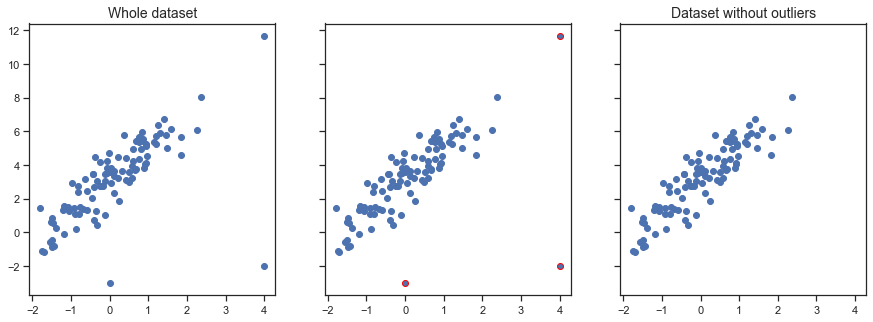

In [36]:
dF2 = dF.drop(outliers)

_, ax = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)

ax[0].scatter(dF.LogSalesVolume2020, dF.LogSalesVolume2021)
ax[1].scatter(dF2.LogSalesVolume2020, dF2.LogSalesVolume2021)
ax[1].scatter(dF.iloc[outliers].LogSalesVolume2020,dF.iloc[outliers].LogSalesVolume2021,color = 'C0',edgecolors='red')
ax[2].scatter(dF2.LogSalesVolume2020, dF2.LogSalesVolume2021)

ax[0].set_title('Whole dataset',fontdict = {'fontsize' : 14})
ax[2].set_title('Dataset without outliers',fontdict = {'fontsize' : 14})


plt.show()

In [37]:
fitted_ols = smf.ols(data = dF2, formula="LogSalesVolume2021 ~ LogSalesVolume2020").fit()
print(fitted_ols.summary())

                            OLS Regression Results                            
Dep. Variable:     LogSalesVolume2021   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     367.4
Date:                Tue, 19 Jul 2022   Prob (F-statistic):           2.06e-34
Time:                        20:42:16   Log-Likelihood:                -128.65
No. Observations:                  97   AIC:                             261.3
Df Residuals:                      95   BIC:                             266.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.1630      0

 We estimated that $\widehat{\beta}_1 = 1.85$ and $\widehat{\beta}_0 = 3.16$ hence our predicted regression function is $\widehat{\mu} = 3.16 + 1.85x$

The regression Functions tells us that the 2021 sales increases by a factor of ~1.85 with respect to sales volume of the year before. 



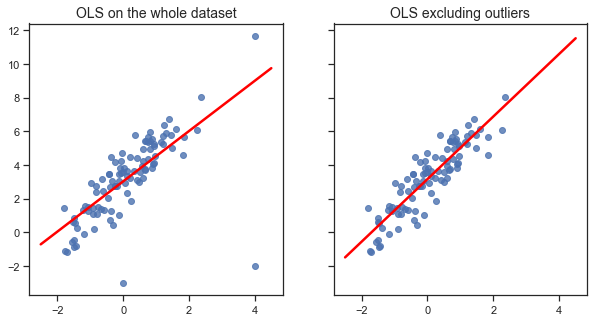

In [38]:
_, ax = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

a = np.linspace(-2.5,4.5,100)

# Regression on dataset with outliers
ax[0].scatter(dF.LogSalesVolume2020,dF.LogSalesVolume2021,alpha=0.8)
ax[0].plot(a, 1.4939 * a + 3.0267, color ='red',lw=2.5)

# Regression on datasete without outliers
ax[1].scatter(dF2.LogSalesVolume2020,dF2.LogSalesVolume2021,alpha=0.8)
ax[1].plot(a, 1.8581 * a + 3.1630,color = 'red',lw=2.5)

# Visualization improvments
ax[0].set_title('OLS on the whole dataset',fontdict = {'fontsize' : 14})
ax[1].set_title('OLS excluding outliers',fontdict = {'fontsize' : 14})

plt.show()

In [39]:
def AbsLoss(t0,t1):
    x = dF.LogSalesVolume2020
    y = dF.LogSalesVolume2021
    return np.sum(abs(y - t0 - x*t1))

In [40]:
theta_sampling = 50
theta_space = np.linspace(0, 5, theta_sampling)
xxt, yyt = np.meshgrid(theta_space, theta_space)
xxt = xxt.flatten()
yyt = yyt.flatten()
all_coeff = np.stack((xxt, yyt), axis=1)
#loss = 0.5*1

losses = []
for par0 in theta_space:
    for par1 in theta_space:
        losses.append(AbsLoss(par0,par1))
        
losses = np.array(losses)
losses = losses.reshape(theta_sampling, theta_sampling)
xxt = xxt.reshape(theta_sampling, theta_sampling)
yyt = yyt.reshape(theta_sampling, theta_sampling)


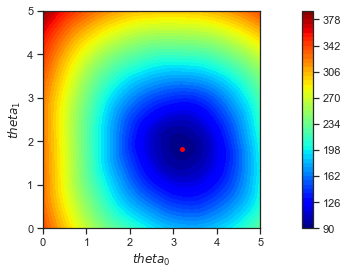

In [45]:
##### plt.rcParams['axes.grid'] = False
%matplotlib inline
plt.rcParams['axes.grid'] = False
plt.contourf(yyt, xxt, losses, levels=50, cmap='jet')
plt.colorbar()
plt.scatter(3.2, 1.8321, color='red', marker='o', s=15)
plt.axis('scaled')
plt.xlabel('$theta_0$')
plt.ylabel('$theta_1$');

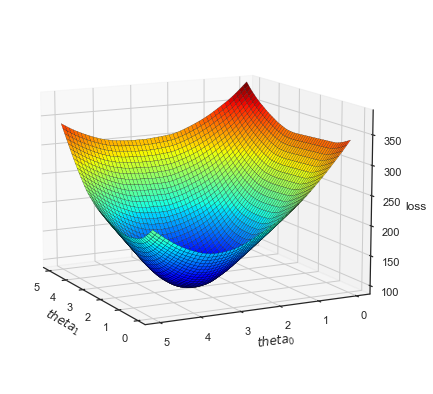

In [46]:
#%matplotlib notebook
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xxt, yyt, losses,linewidth=0.2,cmap='jet',edgecolor='black')
ax.view_init(elev=12,azim=153)
ax.set_xlabel('$theta_1$')
ax.set_ylabel('$theta_0$')
ax.set_zlabel('loss')
plt.show()

![ex1](imgs\\consegna3.PNG)

In [47]:
# 1st Derivative wrt to b_0
def grad_beta_one(b0,b1):
    return np.sum( (-x*y + np.power(x,2)*b1 + x*b0)/(abs(y-x*b1-b0)) )

# 1st Derivative wrt to b_1
def grad_beta_zero(b0,b1):
    return np.sum( (-y +x*b1 + b0 )/(abs(y-x*b1-b0)))

In [49]:
# Initiliaze b_0 and b_1
current_b0 = 0-1
assert current_b0 != 0

current_b1 = 1.0

current_iteration = 0

# Not carefully chosen
learning_Rate = 0.01

previous_step_size_b0 = 0.5
previous_step_size_b1 = 0.5

# To controll the exit from the loop
best_loss = np.inf
loss = 0

tot_it = 0

best_b0 = int()
best_b1 = int()

max_c = sum([ord(x) for x in 'paco']) // 10 + 1 #42 Could be reduced

# Our minimization Algorithm.
while current_iteration <= max_c : 
    previous_b0 = current_b0
    current_b0 = current_b0 - learning_Rate*grad_beta_zero(current_b0,current_b1)
    previous_step_size_b0 = abs(current_b0 - previous_b0)
    
    previous_b1 = current_b1
    current_b1 = current_b1 -learning_Rate*grad_beta_one(current_b0,current_b1)
    previous_step_size_b1 = abs(current_b1 - previous_b1)
    current_iteration += 1
    loss  = np.sum(abs(y - current_b1*x - current_b0))

    if loss < best_loss :
        best_b0 = current_b0
        best_b1 = current_b1 
        best_loss = loss
        tot_it += current_iteration
        current_iteration = 0

# Some Visualization
print(" " * 15 + "Median Regression Results\n" + "=" * 55)
print(f"Total iterations : {tot_it}")
print("-" * 55)
print(f"Best Loss :        {best_loss}")
print(f"b0 :               {best_b0}")
print(f"b1 :               {best_b1}")


               Median Regression Results
Total iterations : 15
-------------------------------------------------------
Best Loss :        91.96530151367188
b0 :               3.2
b1 :               1.8321414965391158


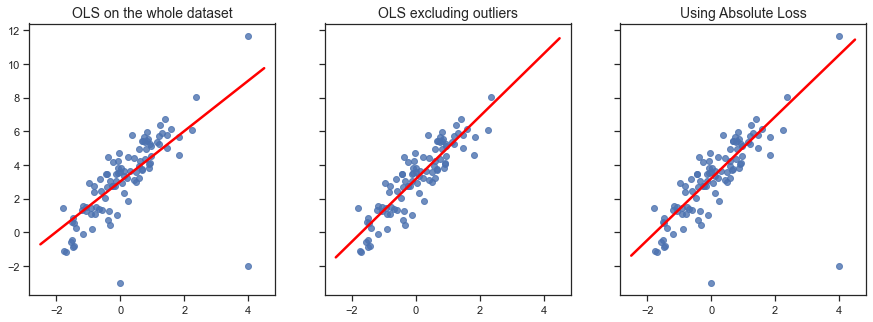

In [50]:
%matplotlib inline
_, ax = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)

a = np.linspace(-2.5,4.5,100)

# Regression on dataset with outliers
ax[0].scatter(dF.LogSalesVolume2020,dF.LogSalesVolume2021,alpha=0.8)
ax[0].plot(a, 1.4939 * a + 3.0267, color ='red',lw=2.5)

# Regression on datasete without outliers
ax[1].scatter(dF2.LogSalesVolume2020,dF2.LogSalesVolume2021,alpha=0.8)
ax[1].plot(a, 1.8581 * a + 3.1630,color = 'red',lw=2.5)

# Regression on datasete without outliers
ax[2].scatter(dF.LogSalesVolume2020,dF.LogSalesVolume2021,alpha=0.8)
ax[2].plot(a, best_b1 * a + best_b0 ,color = 'red',lw=2.5)

# Visualization improvments
ax[0].set_title('OLS on the whole dataset',fontdict = {'fontsize' : 14})
ax[1].set_title('OLS excluding outliers',fontdict = {'fontsize' : 14})
ax[2].set_title('Using Absolute Loss',fontdict = {'fontsize' : 14})


plt.show()

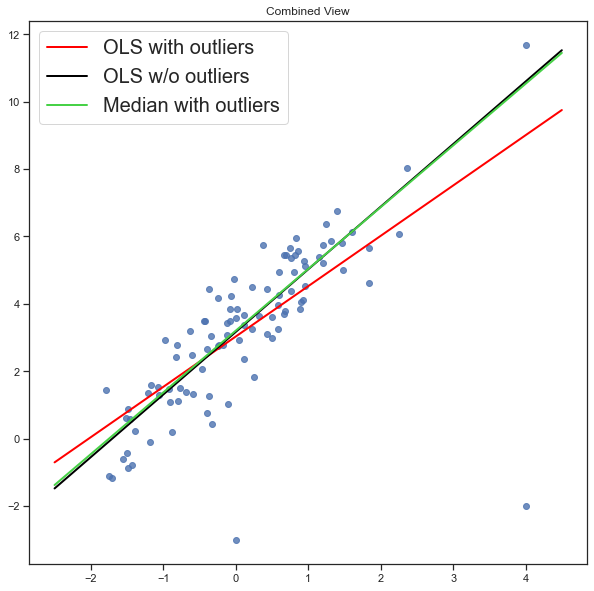

In [53]:
_, ax = plt.subplots(1,1,figsize=(10,10), sharex=True, sharey=True)

ax.set_title("Combined View")

ax.scatter(dF.LogSalesVolume2020,dF.LogSalesVolume2021,alpha=0.8)
ax.plot(a, 1.4939 * a + 3.0267, color ='red',lw=2, label = 'OLS with outliers')
ax.plot(a, 1.8581 * a + 3.1630,color = 'black',lw=2, label = 'OLS w/o outliers')
ax.plot(a, best_b1 * a + best_b0 ,color = '#47d147',lw=2, label = "Median with outliers")

ax.legend(prop = {'size' : 20})

plt.show()